# Assignment

We saw a few examples of machine learning algorithms, so at this point it seems like once you get the data ready, machine learning is just "plug and play", but not so fast! 

In this assignment, we learn about **regularization**! Regularization is a means by which we can control how much a machine learning algorithm learns. The controlling is done using a parameter that the algorithm, called the **shrinkage parameter**, which is just an argument of the algorithm. The shrinkage parameter is an example of a **hyper-parameter**. A hyper-parameter is like a knob: by specifying a different value for the hyper-parameter, we control how the training happens, a process called **hyper-parameter tuning**. We talk about this is more detail in the next lesson.

We will look at two examples of regularizaiton: LASSO and Ridge regression. Both LASSO and Ridge regression are implementations of linear regression where we try to minimize prediction error plus some penalty that depends on the model's parameters (or coefficients) and the shrinkage constant (`alpha` in the code below). LASSO penalizes the model's parameters using the sum of the **absolute values** of the parameters (this is also called **L1-regularization**), while Ridge does so based on the sum of the **squared values** of the parameters (this is also called **L2-regularization**). For reasons we cannot elaborate on here, **LASSO has the by-product that it also does feature selection**, whereas Ridge doesn't. So not all regularization results in feature selection.

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Root Mean Squared Error (RMSE)
Before we dive into regularization we need to have a metric that tells us if our regression is good or bad.  For regressions we measure success differently than with classifications.  Instead of accuracy, the primary measure is **Root Mean Squared Error** (**RMSE**).  A **RMSE** of zero occurs when the predictions are perfect. **RMSE** increases as the predictions get worse. Let's disect the term **Root Mean Squared Error** by understanding each word from right to left.

### Error
The **E** in **RMSE** stands for **E**rror ($e_i$).  The error ($e_i$) is the difference between the known test target value ($y_i$) of sample $i$ and the predicted target value ($\hat{y}_i$) based on the test inputs of sample $i$.
$$e_i = y_i - \hat{y}_i$$
where
- $e_i$ is the error of the $i$th sample
- $y_i$ is the test target value of the $i$th sample
- $\hat{y}_i$ is the predicted target value from the inputs of the $i$th sample

### Squared
The **S** in **RMSE** stands for squared.  The errors ($e_i$) are squared: $(e_i)^2$.  

### Mean
The **M** in **RMSE** stands for mean.  We get the mean squared error (**MSE**) by taking the mean of all the squared errors in the sample:
$$\text{MSE} = \frac{1}{n}\sum_{i}(e_i)^2$$
where
- $\text{MSE}$ is the mean squared error
- $n$ is the number of samples

### Root
The **R** in **RMSE** stands for root.  We get the root mean squared error (**RMSE**) by taking the square root mean of **MSE**
$$\text{RMSE} = \sqrt{\text{MSE}}$$

Both **MSE** and **RMSE** are used to measure the prediction error.  **RMSE** is often preferred because it is in the units of the target variable ($y$), whereas **MSE** is in units of the target variable squared ($y^2$).

0. Compute error metrics.  
<br/>
To make sure we understand RMSE, lets do one small exercise.

We have the following data:
- The actual test target values are: `20, 15, 12, 17, 15, 14, 19, 17`
- The predicted target values predicted from test inputs are: `19, 12, 12, 19, 17, 17, 17, 18`

Determine and show
1. the 8 errors
2. the 8 squared errors derived from the errors
3. the MSE derived from the 8 squared errors
4. the RMSE derived from the MSE
5. the RMSE derived from the actual test target values and the predicted target values using sklearn.metrics.mean_squared_error with squared=False
<br/><span style="color:red" float:right>[1 point]</span>

In [161]:
# Add Code here
from sklearn.metrics import mean_squared_error 
target = np.array([20, 15, 12, 17, 15, 14, 19, 17])
actual = np.array([19, 12, 12, 19, 17, 17, 17, 18])
errors = target - actual
print(f"the 8 errors: {[*errors]}")
squared_errors = errors**2
print(f"the 8 squared errors: {[*squared_errors]}")
MSE = squared_errors.mean()
print(f"MSE: {MSE}")
RMSE = np.sqrt(MSE)
print(f"RMSE: {RMSE}")
print(f"RMSE from sklern: {mean_squared_error(y_true=target, y_pred=actual, squared=False)}")


the 8 errors: [1, 3, 0, -2, -2, -3, 2, -1]
the 8 squared errors: [1, 9, 0, 4, 4, 9, 4, 1]
MSE: 4.0
RMSE: 2.0
RMSE from sklern: 2.0


## Regularization
Let's get back to the main portion of this assignment.  As always we will need data before we can do our work.  Here we will use the California Housing Data.  We will create regressions that predict the median house value in Californian communities.  You can find a description here:  https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [162]:
# Get California Housing Data
from sklearn.datasets import fetch_california_housing
HousingCal = fetch_california_housing()
# 20640 rows × 9 columns
# MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude, MedHouseVal,
df_housing = pd.DataFrame(data=HousingCal['data'], columns=HousingCal['feature_names'])
df_housing[HousingCal['target_names'][0]] = HousingCal['target']

Present the size of the data frame and the first few rows and a histogram for `MedHouseVal`. <br/><span style="color:red" float:right>[0 point]</span>

In [163]:
# Add code here
print(f"Shape: {df_housing.shape}")
df_housing[:5]

Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [164]:
# Determine the number of bins to use with Freedman-Diaconis rule
# code is taken from the Stackoverflow response https://stackoverflow.com/a/33203848
x = df_housing["MedHouseVal"]
q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
n_of_bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", n_of_bins)

Freedman–Diaconis number of bins: 46


Text(0.5, 0, 'Price')

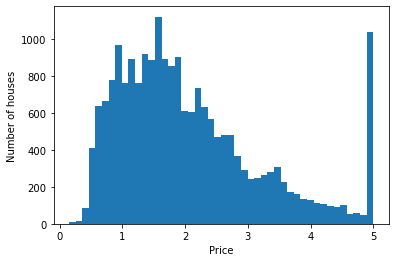

In [165]:
# Histogram for MedHouseVal
plt.hist(df_housing["MedHouseVal"], bins=n_of_bins)
plt.ylabel("Number of houses")
plt.xlabel("Price")

Conclusions: The histogram illustrates that the majority of house values fall within the range of 0.5 to 3.0. Additionally, there is a noticeable quantity of homes priced at 5.0, which appear to be outliers in this dataset and might be excluded during the model training.

It is better to create a model that is limited in its scope, than to include data that are difficult to interpret.  In this case, the prices for houses greater or equal to 5, are mostly incorrect.  

1. Prepare the data

Prepare the data by doing the following:
1. remove the houses where `MedHouseVal` is greater or equal to 5 and present another histogram of `MedHouseVal`
2. remove `Latitude` and `Longitude` because we haven't learned yet how to make these useful
3. split the data into features and target
4. split the features and target into training and test sets
5. normalize the training and test features based on the training data
<br/><span style="color:red" float:right>[1 point]</span>

Text(0.5, 0, 'Price')

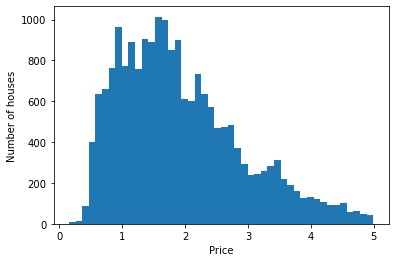

In [166]:
# Add code here
# remove the houses where `MedHouseVal` is greater or equal to 5
df_housing = df_housing[df_housing["MedHouseVal"] < 5]
# Present histogram of MedHouseVal
plt.hist(df_housing["MedHouseVal"], bins=n_of_bins)
plt.ylabel("Number of houses")
plt.xlabel("Price")

In [167]:
# Add code here
# remove `Latitude` and `Longitude`
df_housing.drop(['Latitude', 'Longitude'], axis=1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422
...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,0.847


In [168]:
# Add code here
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# split the data into features and target
X = df_housing[[x for x in df_housing.columns if x != "MedHouseVal"]]
y = df_housing["MedHouseVal"]

# split the features and target into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# normalize the training and test features based on the training data 
# create a scaler object
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

2. Train and Predict
- Train a linear regression algorithm, using `LinearRegression` from `sklearn.linear_model`, to predict `MedHouseVal` on the prepared data.
- predict benchmark values for both training and test data sets.
<br/><span style="color:red" float:right>[1 point]</span>

In [169]:
# Add code here
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train_benchmark = linreg.predict(X_train)
y_hat_test_benchmark = linreg.predict(X_test)

3. Evaluate the model
<br/>Calculate and report the performance (RMSE) on both training and test data. These numbers will serve as our benchmark performance. As a sanity check, create a scatter plot of the bench mark predictions against the actual values for the each of the two (train, test) data sets.
<br/><span style="color:red" float:right>[2 point]</span>

In [170]:
# Add code here
# Calculate and report RMSE
linreg_train_RMSE = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark, squared=False)
linreg_test_RMSE = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark, squared=False)
print(f"Train RMSE: {linreg_train_RMSE}")
print(f"Test RMSE: {linreg_test_RMSE}")

Train RMSE: 0.6295688645403013
Test RMSE: 0.6461490720848608


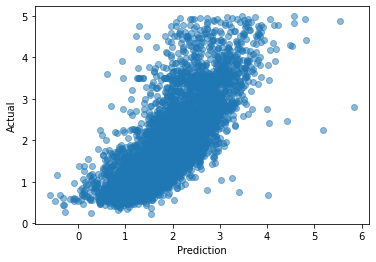

In [171]:
# Add code here
# scatter plot of the bench mark predictions against the actual values
plt.scatter(x=y_hat_test_benchmark, y=y_test, alpha=0.5)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

We now train a regularized version of `LinearRegression` called `Lasso` (you can load it from the sklearn.linear_model.Lasso). `Lasso` has an argument called `alpha`, which is the **shrinkage parameter** we referred to earlier.

4. Let `alpha = 0.000001` and train a `Lasso` model. Show that the resulting model is practically identical to the one we trained with `LinearRegression`. There are different ways to show this, so you will need to think of a way. <span style="color:red" float:right>[2 point]</span>

In [172]:
from sklearn.linear_model import Lasso
# Add code here
alpha = 0.000001
lasso = Lasso(alpha=alpha)
# Train the model
lasso.fit(X_train, y_train)

y_hat_train_benchmark_lasso = lasso.predict(X_train)
y_hat_test_benchmark_lasso = lasso.predict(X_test)
# Add code here
# Compare the models
lasso_train_RMSE = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark_lasso, squared=False)
lasso_test_RMSE = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark_lasso, squared=False)
print(f"Train RMSE for Lasso model: {lasso_train_RMSE}")
print(f"Test RMSE for Lasso model: {lasso_test_RMSE}")

print(f"Difference in RMSE values between 2 moles.\nTrain: Lasso RMSE - Linreg RMSE = {lasso_train_RMSE - linreg_train_RMSE} \nTest: Lasso RMSE - Linreg RMSE = {lasso_test_RMSE - linreg_train_RMSE}")

Train RMSE for Lasso model: 0.6295688645821059
Test RMSE for Lasso model: 0.646149348373874
Difference in RMSE values between 2 moles.
Train: Lasso RMSE - Linreg RMSE = 4.180467083614303e-11 
Test: Lasso RMSE - Linreg RMSE = 0.0165804838335728


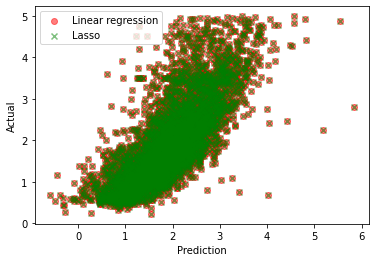

In [173]:
# Display the similarities between Lasso and Linreg similarities by overlapping two scatter plots from the test results
plt.scatter(
    x=y_hat_test_benchmark, y=y_test, c="red", alpha=0.5, label="Linear regression", marker="o"
)
plt.scatter(
    x=y_hat_test_benchmark_lasso,
    y=y_test,
    c="green",
    alpha=0.5,
    label="Lasso",
    marker="x",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.legend(loc="upper left")  # Adds a legend at the upper left corner
plt.show()

#### Comment on the comparison

We can see that both model perform very similarly, and have very little differences in the prediction results

5. Get regression coefficients and performance metrics for varying alpha.  The performance metrics are  RMSE for training and test data.  
<span style="color:red" float:right>[5 point]</span>

In [174]:
# The alpha column contains the values we want to iterate over
# The other columns are for storing the coefficients of the lasso regressions
Coefficients = pd.DataFrame(data=np.arange(0.01, 1, .01), columns=['alpha'])
Coefficients[list(X.columns) + ['RMSE_train', 'RMSE_test']] = 0

To make it easier, we have laid out a suggestion for the code. You can use our layout or you can design your own code.
For each iteration in the suggested design:    
- Train a new `Lasso` model, letting `alpha` change each time to one of the values given by `alpha_vals` below.  
- For each value of `alpha` in `Coefficients`, retrieve the coefficients from the `coef_` attribute of the trained model. 
- Store the coefficients in `Coefficients`
- Predict the training labels, e.g. `y_hat_train`
- Determine the rmse of the training data, e.g. `rmse_train`
- Store the rmse of the training data in `Coefficients`
- Predict the test labels, e.g. `y_hat_test`
- Determine the rmse of the test data, e.g. `rmse_test`
- Store the rmse of the test data in `Coefficients`

In [175]:
Coefficients

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RMSE_train,RMSE_test
0,0.01,0,0,0,0,0,0,0,0,0,0
1,0.02,0,0,0,0,0,0,0,0,0,0
2,0.03,0,0,0,0,0,0,0,0,0,0
3,0.04,0,0,0,0,0,0,0,0,0,0
4,0.05,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94,0.95,0,0,0,0,0,0,0,0,0,0
95,0.96,0,0,0,0,0,0,0,0,0,0
96,0.97,0,0,0,0,0,0,0,0,0,0
97,0.98,0,0,0,0,0,0,0,0,0,0


In [176]:
# Add code here
# loop over the alpha values and do this:
for i, a in enumerate(Coefficients["alpha"]):
    # instantiate a Lasso regression with alpha
    lasso_local = Lasso(alpha=a)
    # fit the lasso regression
    lasso_local.fit(X_train, y_train)

    # add the coefficients to the DataFrame row
    for feature, coef in zip(X.columns, lasso_local.coef_):
        Coefficients.loc[i, feature] = coef
        
    # predict training labels (y_hat for training)
    y_hat_train_benchmark_lasso_local = lasso_local.predict(X_train)
    # determine training error metric (RMSE)
    lasso_train_RMSE_local = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark_lasso_local, squared=False)
    # add the training error metric (RMSE) to the DataFrame row
    Coefficients.loc[i, "RMSE_train"] = lasso_train_RMSE_local
    # predict test labels (y_hat for test)
    y_hat_test_benchmark_lasso_local = lasso_local.predict(X_test)
    # determine test error metric (RMSE)
    lasso_test_RMSE_local = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark_lasso_local, squared=False)
    # add the test error metric (RMSE) to the DataFrame row
    Coefficients.loc[i, "RMSE_test"] = lasso_test_RMSE_local

In [177]:
Coefficients

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RMSE_train,RMSE_test
0,0.01,0.624910,0.099908,-0.12343,0.142366,0,-0.025979,-0.704371,-0.670887,0.633703,0.652422
1,0.02,0.577087,0.101569,-0.00000,0.016081,0,-0.014678,-0.606337,-0.565671,0.645596,0.665322
2,0.03,0.578982,0.103945,-0.00000,0.000000,0,-0.004614,-0.462897,-0.422725,0.657368,0.678239
3,0.04,0.581466,0.107006,-0.00000,0.000000,0,-0.000000,-0.327876,-0.287641,0.671538,0.693242
4,0.05,0.584109,0.110173,-0.00000,0.000000,0,-0.000000,-0.192760,-0.152451,0.689043,0.711386
...,...,...,...,...,...,...,...,...,...,...,...
94,0.95,0.000000,0.000000,0.00000,-0.000000,0,-0.000000,-0.000000,-0.000000,0.967586,0.981549
95,0.96,0.000000,0.000000,0.00000,-0.000000,0,-0.000000,-0.000000,-0.000000,0.967586,0.981549
96,0.97,0.000000,0.000000,0.00000,-0.000000,0,-0.000000,-0.000000,-0.000000,0.967586,0.981549
97,0.98,0.000000,0.000000,0.00000,-0.000000,0,-0.000000,-0.000000,-0.000000,0.967586,0.981549


6. Lasso changes with alpha
<br/>
(a) Using a visual, show how the performance on the training and test data changed as we gradually increased the shrinkage parameter `alpha`. At which point is there a substantial decrease in performance (increase in RMSE) on the test data?  You might want to use a log scale (`plt.xscale('log')`) for `alpha`.
<br/>
(b) Using a visual, show how the model's coefficients changed as we gradually increased the shrinkage parameter `alpha`. HINT: They should appear to be shrinking toward zero as you increase `alpha`. 
<br/><span style="color:red" float:right>[4 point]</span>

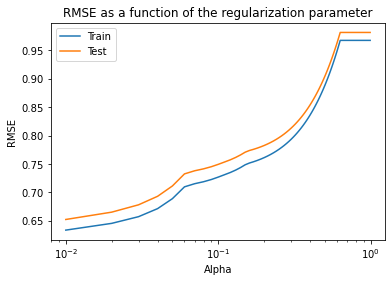

In [178]:
# Add code here
# RMSE vs. alpha

# (a)
plt.plot(Coefficients['alpha'], Coefficients['RMSE_train'], label='Train')
plt.plot(Coefficients['alpha'], Coefficients['RMSE_test'], label='Test')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE as a function of the regularization parameter')
plt.show()

The point where the test curve starts to increase substantially is the point where the model starts to underfit.

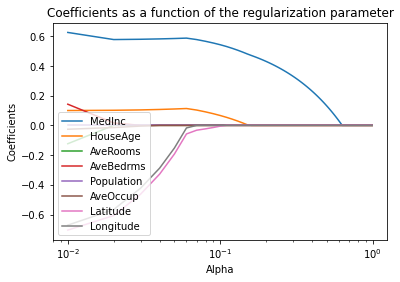

In [179]:
# Add code here
# Coefficient vs. alpha
for col in X.columns:
    plt.plot(Coefficients["alpha"], Coefficients[col], label=col)

plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Coefficients")
plt.legend()
plt.title("Coefficients as a function of the regularization parameter")
plt.show()

7. Compare `Ridge` and `Lasso` baseline models.  Show that `Ridge` and `Lasso` return the same trained model when `alpha = 0.00001` (i.e. close to zero). <br/><span style="color:red" float:right>[1 point]</span>

In [180]:
# Add code here
from sklearn.linear_model import Ridge
# Add code here
alpha = 0.000001
ridge = Ridge(alpha=alpha)

# fit the ridge regression
# Train the model
ridge.fit(X_train, y_train)

# compare the coefficients
print("Ridge coefficients: ", ridge.coef_)
print("Lasso coefficients: ", lasso.coef_)

y_hat_train_benchmark_ridge = ridge.predict(X_train)
y_hat_test_benchmark_ridge = ridge.predict(X_test)
# Add code here
# Compare the models
ridge_train_RMSE = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark_ridge, squared=False)
ridge_test_RMSE = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark_ridge, squared=False)
# compare predicted test labels (y_hat for test)
print(f"Difference in RMSE values between 2 moles.\nTrain: Ridge RMSE - Linreg RMSE = {ridge_train_RMSE - linreg_train_RMSE} \nTest: Ridge RMSE - Linreg RMSE = {ridge_test_RMSE - linreg_train_RMSE}")

Ridge coefficients:  [ 0.6752695   0.09969043 -0.25264898  0.27387242  0.00434046 -0.03765128
 -0.79891801 -0.77341021]
Lasso coefficients:  [ 0.67526456  0.09969033 -0.2526363   0.27385943  0.00433961 -0.03765008
 -0.79890846 -0.77339984]
Difference in RMSE values between 2 moles.
Train: Ridge RMSE - Linreg RMSE = 0.0 
Test: Ridge RMSE - Linreg RMSE = 0.016580207555852988


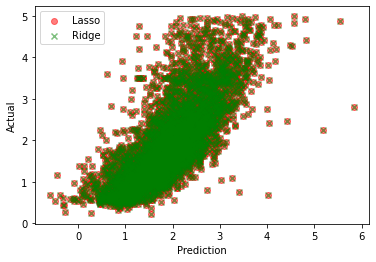

In [181]:
# Display difference between Ridge and Lasso models predictions
plt.scatter(
    x=y_hat_test_benchmark_lasso, y=y_test, c="red", alpha=0.5, label="Lasso", marker="o"
)
plt.scatter(
    x=y_hat_test_benchmark_ridge,
    y=y_test,
    c="green",
    alpha=0.5,
    label="Ridge",
    marker="x",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.legend(loc="upper left")  # Adds a legend at the upper left corner
plt.show()

8. Get regression coefficients and performance metrics for varying `alpha` on a ridge regression.  The performance metrics are  RMSE for training and test data.  In other words, repeat the above using `Ridge` instead of `Lasso`.   For `ridge`, we will use the following range for `alpha`: `np.power(2., np.arange(1., 25., 1.))`

> Note: Ridge has a  different behaviour than Lasso. Coefficients will very gradually approach zero and not have a steep drop off. You probably will not notice any zero coefficients.

<br/><span style="color:red" float:right>[1 point]</span>

In [182]:
# Add code here
# Determine alpha_values
alpha_values = np.power(2., np.arange(1., 25., 1.))
# The alpha column contains the values we want to iterate over
# The other columns are for storing the coefficients of the ridge regressions
Coefficients = pd.DataFrame(data=alpha_values, columns=['alpha'])
Coefficients[list(X.columns) + ['RMSE_train', 'RMSE_test']] = np.float('nan')

/tmp/ipykernel_161/457060659.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Coefficients[list(X.columns) + ['RMSE_train', 'RMSE_test']] = np.float('nan')


In [183]:
# Add code here
# loop over the alpha values and do this:
for i, a in enumerate(Coefficients["alpha"]):
    # instantiate a ridge regression with alpha
    ridge_local = Ridge(alpha=a)
    # fit the ridge regression
    ridge_local.fit(X_train, y_train)

    # add the coefficients to the DataFrame row
    for feature, coef in zip(X.columns, ridge_local.coef_):
        Coefficients.loc[i, feature] = coef
        
    # predict training labels (y_hat for training)
    y_hat_train_benchmark_ridge_local = ridge_local.predict(X_train)
    # determine training error metric (RMSE)
    ridge_train_RMSE_local = mean_squared_error(y_true=y_train, y_pred=y_hat_train_benchmark_ridge_local, squared=False)
    # add the training error metric (RMSE) to the DataFrame row
    Coefficients.loc[i, "RMSE_train"] = ridge_train_RMSE_local
    # predict test labels (y_hat for test)
    y_hat_test_benchmark_ridge_local = ridge_local.predict(X_test)
    # determine test error metric (RMSE)
    ridge_test_RMSE_local = mean_squared_error(y_true=y_test, y_pred=y_hat_test_benchmark_ridge_local, squared=False)
    # add the test error metric (RMSE) to the DataFrame row
    Coefficients.loc[i, "RMSE_test"] = ridge_test_RMSE_local

9. Ridge changes with alpha
<br/>
(a) Using a visual, show how the performance on the training and test data changed as we gradually increased `alpha` for `Ridge`. In other words, repeat the above using `Ridge` instead of `Lasso`.  
<br/>
(b) Using a visual, show how the model's coefficients for ridge changed as we gradually increased the shrinkage parameter `alpha`.  
<br/><span style="color:red" float:right>[2 point]</span>

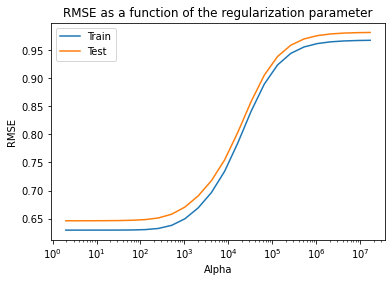

In [184]:
# Add code here
# RMSE vs. alpha
import matplotlib.pyplot as plt

# (a)
plt.plot(Coefficients['alpha'], Coefficients['RMSE_train'], label='Train')
plt.plot(Coefficients['alpha'], Coefficients['RMSE_test'], label='Test')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE as a function of the regularization parameter')
plt.show()

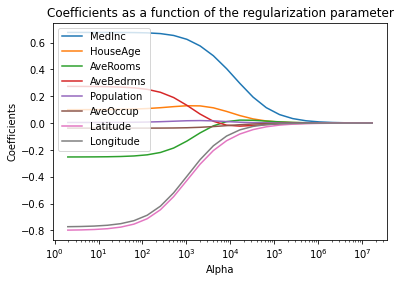

In [185]:
# Add code here
# Coefficient vs. alpha
for col in X.columns:
    plt.plot(Coefficients['alpha'], Coefficients[col], label=col)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Coefficients as a function of the regularization parameter')
plt.show()


10. Based on the results, briefly describe the effect of changing `alpha` on the coefficients of both `Ridge` and `Lasso`. What value of `alpha` would you choose for each case? You do not need to give a precise answer, but choose a number. <br/><span style="color:red" float:right>[2 point]</span>

#### Comments on regularization using ridge and lasso
For Lasso, I would opt for `alpha = 0.04`. This is the threshold where the coefficients begin to shrink considerably, resulting in the model becoming less sensitive to variations in the data, thereby escalating the Root Mean Square Error (RMSE). 

Similarly, for Ridge regression, I would propose `alpha = 10^3`. It is around this point that the coefficients begin to diminish significantly, thereby lessening the model's responsiveness to changes in the data and leading to a rise in the RMSE.

# End of assignment